# Train model on CAN Data

### Explore automatic classification of steering angle

The goal of this notebook is to explore the automatic classification of steering angle in CAN signals.
A model is trained on snippets on can signals from steering and non steering can messages.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
file_list=[
    {
        "vehicle_name": "Chrysler Pacifica 2018",
        "dbc_name": "opendbc/chrysler_pacifica_2017_hybrid.dbc",
        "steer_brake_acc": [258, 284, 308],
        "file_name": "exported_csvs/6fb4948a7ebe670e_2019-11-12--00-35-53.bz2.csv"
    },
    {
        "vehicle_name": "Toyota Prius Prime 2020",
        "dbc_name": "opendbc/toyota_prius_2017_pt_generated.dbc",
        "steer_brake_acc": [37, 166, 581], # acc input looks strange
        "file_name": "exported_csvs/eb378db0873da597_2020-02-29--11-50-42--0--rlog.bz2.csv"
    },
    {
        "vehicle_name": "Acura ILX",
        "dbc_name": "opendbc/acura_ilx_2016_can_generated.dbc",
        "steer_brake_acc": [342, 420, 304], # acc input looks strange
        "file_name": "exported_csvs/rlog.bz2.csv"
    },    
]

In [4]:
file_path = "exported_csvs/rlog.bz2.csv"
sequences = list()
df = pd.read_csv(file_path, header=0)
values = df.values

In [5]:
len(values)

10882

In [6]:
targets = np.ones(len(values))*342

In [7]:
targets

array([342., 342., 342., ..., 342., 342., 342.])

In [8]:
from sklearn import preprocessing

x = df.values #returns a numpy array
columns = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = columns

In [9]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [10]:
df

,145,342,398,399,819,821,304,316,344,380,...,888,923,773,985,929,1034,1029,1064,1365,busTime
0,0.517419,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.517419,0.999405,0.810548,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000090
2,0.517419,0.999405,0.810571,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000188
3,0.517419,0.999405,0.810571,0.002274,1.0,1.000000,5.800570e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000283
4,0.517419,0.999405,0.810501,0.002152,1.0,1.000000,5.881886e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,0.517135,0.999329,0.810432,0.993683,1.0,0.966322,3.936869e-03,0.000001,7.135548e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999628
10878,0.517135,0.999329,0.810432,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999716
10879,0.517135,0.999329,0.810455,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999811
10880,0.517135,0.999329,0.810455,0.993591,1.0,0.966322,3.952128e-03,0.000001,7.111097e-15,9.909291e-07,...,1.0,0.001432,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999911


In [721]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def create_X_y_balanced(df, num_samples, sample_length):
    X = np.zeros([num_samples, sample_length])
    y = np.zeros(num_samples)
    for i in range(num_samples):
        # Half the time add a steering sample
        add_true_sample = randint(0,1)==1
        if add_true_sample:
            signal_index = 1 #steering value for acura ilx
        else:
            # Randomly choose which signal to write from
            signal_index = randint(0,df.shape[1]-1)
        chunk = []
        #print(signal_index)
        starting_point = randint(0,df.shape[0]-sample_length)
        
        for j in range(sample_length):
            # Since signal is very long, only a snippet is taken
            X[i][j] = df.iat[j+starting_point,signal_index]
            
        # Now create label based on what signal id we saved from    
        if df.columns[signal_index] in ["342"]: #steering value for acura ilx
            np.append(y,1)
            y[i]=1
        else:
            y[i]=0
    return [X,y]
    

X, y = create_X_y_balanced(df, 6000, 784)

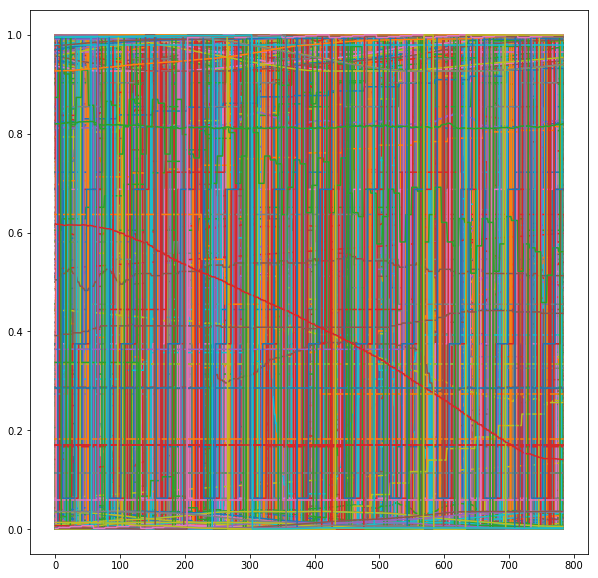

In [722]:
plt.figure(figsize=(10,10))
for i in range(0,X.shape[0]):
    plt.plot(X[i][:])
plt.show()

In [723]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [724]:
#X_train = np.expand_dims(X_train, axis=2)

In [725]:
#X_test = np.expand_dims(X_test, axis=2)

In [734]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Conv2D, Flatten
model = Sequential()
#model.add(Conv1D(32, 3, activation="relu", input_shape=(784,1)))
#model.add(Flatten())
model.add(Dense(50, activation="relu", input_shape=(784,)))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))

model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 50)                39250     
_________________________________________________________________
dense_109 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_110 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 11        
Total params: 41,101
Trainable params: 41,101
Non-trainable params: 0
_________________________________________________________________


In [735]:
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

In [736]:
y_train.shape

(4800,)

In [737]:
model.fit(X_train, y_train, batch_size=100, epochs=500)

Train on 4800 samples
Epoch 1/500
4800/4800 [==============================] - 0s 52us/sample - loss: 0.6143 - accuracy: 0.7904
Epoch 2/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.5115 - accuracy: 0.8173
Epoch 3/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4653 - accuracy: 0.8263
Epoch 4/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4424 - accuracy: 0.8256
Epoch 5/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4287 - accuracy: 0.8321
Epoch 6/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4219 - accuracy: 0.8356
Epoch 7/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4173 - accuracy: 0.8369
Epoch 8/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.4127 - accuracy: 0.8390
Epoch 9/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.4078 - accuracy: 0.8396
Epoch 10/500
4800/4800 [

4800/4800 [==============================] - 0s 12us/sample - loss: 0.3291 - accuracy: 0.8798
Epoch 78/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.3281 - accuracy: 0.8785
Epoch 79/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.3289 - accuracy: 0.8785
Epoch 80/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3279 - accuracy: 0.8792
Epoch 81/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3252 - accuracy: 0.8792
Epoch 82/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3264 - accuracy: 0.8796
Epoch 83/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3234 - accuracy: 0.8806
Epoch 84/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.3244 - accuracy: 0.8792
Epoch 85/500
4800/4800 [==============================] - 0s 14us/sample - loss: 0.3243 - accuracy: 0.8813
Epoch 86/500
4800/4800 [==========================

4800/4800 [==============================] - 0s 12us/sample - loss: 0.2923 - accuracy: 0.8888
Epoch 154/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2911 - accuracy: 0.8888
Epoch 155/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2913 - accuracy: 0.8885
Epoch 156/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2873 - accuracy: 0.8900
Epoch 157/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2936 - accuracy: 0.8888
Epoch 158/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2870 - accuracy: 0.8904
Epoch 159/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3243 - accuracy: 0.8796
Epoch 160/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.3136 - accuracy: 0.8729
Epoch 161/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2909 - accuracy: 0.8879
Epoch 162/500
4800/4800 [=================

Epoch 229/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2763 - accuracy: 0.8923
Epoch 230/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2716 - accuracy: 0.8944
Epoch 231/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2678 - accuracy: 0.8950
Epoch 232/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2691 - accuracy: 0.8946
Epoch 233/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2692 - accuracy: 0.8946
Epoch 234/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2652 - accuracy: 0.8952
Epoch 235/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2817 - accuracy: 0.8915
Epoch 236/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2659 - accuracy: 0.8948
Epoch 237/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2711 - accuracy: 0.8931
Epoch 238/500
4800/4800 [===

4800/4800 [==============================] - 0s 11us/sample - loss: 0.2707 - accuracy: 0.8919
Epoch 305/500
4800/4800 [==============================] - 0s 13us/sample - loss: 0.2682 - accuracy: 0.8963
Epoch 306/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2608 - accuracy: 0.8975
Epoch 307/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2629 - accuracy: 0.8973
Epoch 308/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2606 - accuracy: 0.8996
Epoch 309/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2578 - accuracy: 0.9000
Epoch 310/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2576 - accuracy: 0.8977
Epoch 311/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2606 - accuracy: 0.8977
Epoch 312/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2588 - accuracy: 0.8975
Epoch 313/500
4800/4800 [=================

Epoch 380/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2384 - accuracy: 0.9050
Epoch 381/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2368 - accuracy: 0.9077
Epoch 382/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2374 - accuracy: 0.9077
Epoch 383/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2362 - accuracy: 0.9058
Epoch 384/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2530 - accuracy: 0.9021
Epoch 385/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2388 - accuracy: 0.9060
Epoch 386/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2361 - accuracy: 0.9077
Epoch 387/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2359 - accuracy: 0.9090
Epoch 388/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2373 - accuracy: 0.9071
Epoch 389/500
4800/4800 [===

4800/4800 [==============================] - 0s 11us/sample - loss: 0.2322 - accuracy: 0.9085
Epoch 456/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2290 - accuracy: 0.9092
Epoch 457/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2290 - accuracy: 0.9096
Epoch 458/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2280 - accuracy: 0.9098
Epoch 459/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2311 - accuracy: 0.9100
Epoch 460/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2287 - accuracy: 0.9098
Epoch 461/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2286 - accuracy: 0.9098
Epoch 462/500
4800/4800 [==============================] - 0s 12us/sample - loss: 0.2260 - accuracy: 0.9115
Epoch 463/500
4800/4800 [==============================] - 0s 11us/sample - loss: 0.2330 - accuracy: 0.9073
Epoch 464/500
4800/4800 [=================

In [738]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1200/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [215]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def extract_random_sample(df, sample_length):
    x = np.zeros(sample_length)
    # Randomly choose which signal to write from
    signal_index = randint(0,df.shape[1]-1)
    chunk = []
    #print(signal_index)
    starting_point = randint(0,df.shape[0]-sample_length)

    for j in range(sample_length):
        # Since signal is very long, only a snippet is taken
        x[j] = df.iat[j+starting_point,signal_index]

    return x
    

x = extract_random_sample(df, 784)

x=np.tile(x,(1,1))

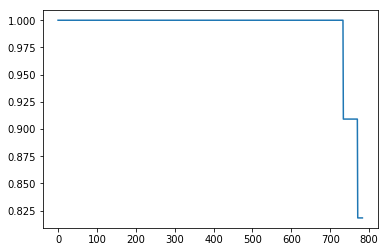

In [216]:
plt.plot(x[0][:])

In [217]:
x.shape

(1, 784)

In [218]:

result = model.predict(x)

In [219]:
len(result)

1

In [209]:
help(model)

Help on Sequential in module tensorflow.python.keras.engine.sequential object:

class Sequential(tensorflow.python.keras.engine.training.Model)
 |  Sequential(layers=None, name=None)
 |  
 |  Linear stack of layers.
 |  
 |  Arguments:
 |      layers: list of layers to add to the model.
 |  
 |  Example:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dens

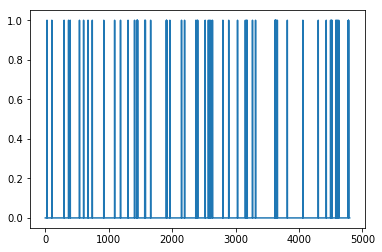

In [220]:
plt.plot(y_train)

In [222]:
np.mean(y_train)

0.0125

In [223]:
result = model.predict(X_train)

In [224]:
result

array([[0.00312996],
       [0.33886862],
       [0.00101224],
       ...,
       [0.00101224],
       [0.00622189],
       [0.00351337]], dtype=float32)

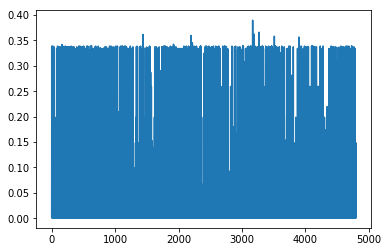

In [227]:
plt.plot(result)

# DEMO

In [803]:
np.where(y_test==1)

(array([   0,    1,    2,    4,    6,   11,   12,   16,   19,   22,   25,
          27,   29,   36,   37,   38,   39,   40,   41,   42,   43,   45,
          46,   49,   52,   54,   55,   57,   58,   60,   61,   62,   64,
          66,   69,   71,   73,   74,   75,   79,   80,   81,   84,   85,
          90,   91,   92,   95,   97,   98,   99,  103,  106,  108,  109,
         110,  113,  116,  118,  120,  121,  124,  126,  128,  129,  132,
         133,  135,  136,  139,  140,  142,  144,  145,  147,  148,  150,
         156,  158,  160,  161,  163,  167,  169,  172,  173,  177,  178,
         180,  182,  185,  187,  188,  190,  191,  193,  201,  203,  206,
         207,  208,  209,  212,  214,  216,  217,  224,  226,  227,  230,
         231,  232,  233,  237,  239,  241,  242,  244,  245,  246,  247,
         248,  251,  252,  253,  254,  261,  262,  263,  265,  268,  269,
         270,  271,  272,  273,  276,  277,  280,  281,  282,  286,  289,
         292,  293,  295,  296,  297, 

In [878]:
index = 23 #37 #23

In [879]:
x = X_test[index]
x = np.tile(x,(1,1))

In [880]:
x.shape

(1, 784)

In [881]:
y_test[index]

0.0

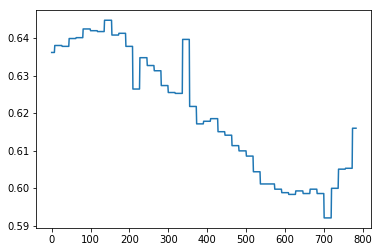

In [882]:
plt.plot(x[0])

In [883]:
x.shape

(1, 784)

In [884]:
model.predict(x)

array([[0.05492169]], dtype=float32)

# --------------------

In [811]:
steering_samples_indexes = np.where(y_train==1)

In [812]:
x=X_train[index][:]
x=np.tile(x,(1,1))

In [813]:
predictions = model.predict(X_train)

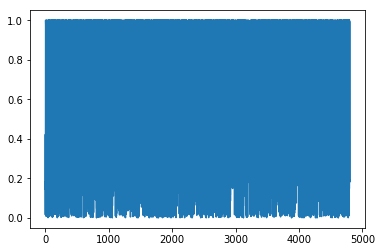

In [814]:
plt.plot(predictions)

In [430]:
# Issue: samples are almost always non steering so model just predicts not steering all the time

In [431]:
np.mean(predictions)

0.046590727

In [432]:
np.max(predictions)

0.38964254

# Results

It is possible to classify steering and non steering signals in a can bus with 80% accuracy using a neural net.

TODOs
* Train the model on the can bus of more than one vehicle. Even though can ids were not given to the network, it is possible that the network learned to discern steering vs non-steering based on features specific to this vehicle.
* Add a convnet. The current model uses just dense layers which are not ideal for detecting the shape of signals
* Add angle unwrapping to remove angle jumps
